# The political and economic consequences of COVID-19

In [80]:
import numpy as np
import pandas as pd
import glob
import config
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
pd.set_option('display.max_rows', 500)

## What is happening?

In December, 2019, the first case of the novel coronavirus COVID-19 was discovered in Wuhan, China. The desease seemed to have developed on a wet market in the city of Wuhan and quickly spread across the Province Hubei.

## Data Collection
### COVID-19

In [3]:
# load data from https://github.com/CSSEGISandData/COVID-19
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')


In [4]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,48,50,50,50,53,59,70,75,82,114
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,420,461,502,511,581,639,639,701,773,839
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,130,138,150,150,160,178,178,200,212,226
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,83,93,99,117,129,149,149,197,238,428


### News

In [5]:
# load the news stories which were extracted from Media Cloud
df_news = pd.read_csv('news/covid-19-or-coronavirus-or-all-story-urls-20200315082840.csv')
df_news.head()


,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
0,1483691901,2020-01-01 02:15:15,19 Things You Won't Understand If You Were Bor...,https://www.buzzfeed.com/daniellaemanuel/kids-...,en,False,NaN,6218,Buzzfeed,http://www.buzzfeed.com
1,1483736058,2020-01-01 00:00:28,"Kings ride power play, 4-goal first period pas...",https://www.dailynews.com/2019/12/31/kings-rid...,en,False,NaN,24901,bleacherreport.com,http://bleacherreport.com
2,1483742069,2020-01-01 00:22:23,"Neal records hat trick in 4-point game, Oilers...",https://www.kansascity.com/entertainment/artic...,en,False,NaN,30,The Kansas City Star,http://www.kansascity.com/
3,1483743956,2020-01-01 00:15:24,"Kane scores twice, leads Blackhawks to 5-3 win...",http://www.startribune.com/kane-scores-twice-l...,en,False,NaN,19,Star Tribune,http://www.startribune.com/
4,1483743953,2020-01-01 00:25:06,"Neal records hat trick in 4-point game, Oilers...",http://www.startribune.com/neal-records-hat-tr...,en,False,NaN,19,Star Tribune,http://www.startribune.com/


In [6]:
# how many news stories matching my coronavirus query were published sind January 1st?
df_news.shape


(85809, 10)

In [7]:
# load the news about Biden, Sanders and the primary and general elections in 2020
df_news_politics = pd.read_csv('news/biden-or-sanders-or-primary-all-story-urls-20200315125902.csv')
df_news_politics.head()


,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
0,1177339361,2020-02-15 00:00:00,Walker says Madison voters driven by anger,http://archive.jsonline.com/news/statepolitics...,en,False,NaN,36,Milwaukee Journal Sentinel,http://www.jsonline.com/
1,1177816610,2020-02-15 00:00:00,"'Pod Save America' host: After Trump, politics...",https://www.sfchronicle.com/politics/article/P...,NaN,False,NaN,14,sfchronicle,http://www.sfgate.com/
2,1449604986,2020-01-15 00:00:00,Janison: California as Democratic HQ of the U.S.,https://www.newsday.com/long-island/columnists...,en,False,NaN,13,Newsday,http://www.newsday.com/
3,1483740563,2020-01-01 00:01:49,Giuliani Says He’s Prepared to ‘Do Demonstrati...,http://feedproxy.google.com/~r/thedailybeast/a...,en,False,NaN,1707,The Daily Beast,http://www.thedailybeast.com/
4,1483750136,2020-01-01 00:36:36.812637,California Election Results 2014: House Map by...,https://www.politico.com/2014-election/results...,en,False,NaN,18268,Politico,https://www.politico.com/


### Financial data

In [32]:
# load financial data for commodities, stocks, bonds and currencies from Yahoo financial
# this code was adapted from this project https://github.com/julianikulski/bike-sharing/blob/master/dataset_creation.ipynb
path = r'C:\Users\julia\Documents\Coding\own-projects\covid-19\finance-data'
all_files = glob.glob(path + "/*.csv")

df_list = []

for file in all_files:
    df_temp = pd.read_csv(file)
    df_temp['asset'] = file[67:-4]
    df_list.append(df_temp)
    
df_fin = pd.concat(df_list, axis=0, ignore_index=True)

# print the first 5 rows of the new dataframe
df_fin.head()


,Date,Open,High,Low,Close,Adj Close,Volume,asset
0,1985-01-02,11.70,11.70,11.70,11.70,11.70,0.0,10y_bond
1,1985-01-03,11.62,11.62,11.62,11.62,11.62,0.0,10y_bond
2,1985-01-04,11.67,11.67,11.67,11.67,11.67,0.0,10y_bond
3,1985-01-06,NaN,NaN,NaN,NaN,NaN,NaN,10y_bond
4,1985-01-07,11.50,11.50,11.50,11.50,11.50,0.0,10y_bond


In [9]:
# get the descriptive statistics of the financial data
df_fin.describe(include='all')


,Date,Open,High,Low,Close,Adj Close,Volume,asset
count,86660,81749.000000,81749.000000,81749.000000,81749.000000,81749.000000,8.174900e+04,86660
unique,14822,NaN,NaN,NaN,NaN,NaN,NaN,12
top,2017-06-27,NaN,NaN,NaN,NaN,NaN,NaN,nasdaq
freq,12,NaN,NaN,NaN,NaN,NaN,NaN,12385
mean,NaN,3677.534158,3702.735706,3649.429121,3677.268965,3677.268965,5.897875e+08,NaN
std,NaN,6059.607822,6096.584551,6016.677397,6058.019540,6058.019540,1.960215e+09,NaN
min,NaN,0.484000,0.601000,0.072902,0.499000,0.499000,0.000000e+00,NaN
25%,NaN,67.239998,68.220001,66.260002,67.320000,67.320000,0.000000e+00,NaN
50%,NaN,902.440002,911.020020,890.500000,902.200989,902.200989,2.402470e+05,NaN
75%,NaN,4267.339844,4308.819824,4222.479980,4266.169922,4266.169922,2.529100e+08,NaN


### Polls and approval ratings

In [10]:
# read in the detailed poll list of trump approval rating polls
df_approval_polls = pd.read_csv('trump-approval-ratings/approval_polllist.csv')
df_approval_polls.head()


,president,subgroup,modeldate,startdate,enddate,pollster,grade,samplesize,population,weight,...,disapprove,adjusted_approve,adjusted_disapprove,multiversions,tracking,url,poll_id,question_id,createddate,timestamp
0,Donald Trump,All polls,3/13/2020,1/20/2017,1/22/2017,Gallup,B,1500.0,a,0.241682,...,45.0,45.688900,43.597418,NaN,T,http://www.gallup.com/poll/201617/gallup-daily...,49253,77265,1/23/2017,15:42:28 13 Mar 2020
1,Donald Trump,All polls,3/13/2020,1/20/2017,1/22/2017,Morning Consult,B/C,1992.0,rv,0.696984,...,37.0,44.661605,38.336711,NaN,NaN,http://static.politico.com/9b/13/82a3baf542ae9...,49249,77261,1/23/2017,15:42:28 13 Mar 2020
2,Donald Trump,All polls,3/13/2020,1/21/2017,1/23/2017,Gallup,B,1500.0,a,0.223234,...,46.0,45.688900,44.597418,NaN,T,http://www.gallup.com/poll/201617/gallup-daily...,49262,77274,1/24/2017,15:42:28 13 Mar 2020
3,Donald Trump,All polls,3/13/2020,1/20/2017,1/24/2017,Ipsos,B-,1632.0,a,0.150785,...,45.2,42.849266,44.055551,NaN,T,http://polling.reuters.com/#poll/CP3_2/,49426,77599,3/1/2017,15:42:28 13 Mar 2020
4,Donald Trump,All polls,3/13/2020,1/22/2017,1/24/2017,Gallup,B,1500.0,a,0.208659,...,45.0,46.688900,43.597418,NaN,T,http://www.gallup.com/poll/201617/gallup-daily...,49236,77248,1/25/2017,15:42:28 13 Mar 2020


In [11]:
# read in the topline of trump approval ratings
df_approval_top = pd.read_csv('trump-approval-ratings/approval_topline.csv')
df_approval_top.head()


,president,subgroup,modeldate,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,timestamp
0,Donald Trump,Voters,3/13/2020,43.348265,47.682492,39.014038,52.652942,56.514916,48.790968,15:44:49 13 Mar 2020
1,Donald Trump,Adults,3/13/2020,41.706265,45.338979,38.073552,53.407293,57.514376,49.300210,15:43:24 13 Mar 2020
2,Donald Trump,All polls,3/13/2020,42.287014,46.770330,37.803697,53.232598,57.219694,49.245502,15:42:28 13 Mar 2020
3,Donald Trump,Adults,3/12/2020,41.851013,45.435107,38.266919,53.233543,57.289662,49.177423,16:58:21 12 Mar 2020
4,Donald Trump,Voters,3/12/2020,43.264426,47.517777,39.011074,52.706389,56.557767,48.855011,16:59:45 12 Mar 2020


In [12]:
# read in polls for presidential election



## Data Analysis
### Covid-19 cases

In [13]:
# check the US numbers
df_confirmed_countries = df_confirmed.groupby('Country/Region').sum()
df_confirmed_countries.reset_index(inplace=True)

df_confirmed_US = df_confirmed_countries[df_confirmed_countries['Country/Region'] == 'US']
plot_df_confirmed_US = df_confirmed_US.drop(columns=['Lat', 'Long', 'Country/Region'])


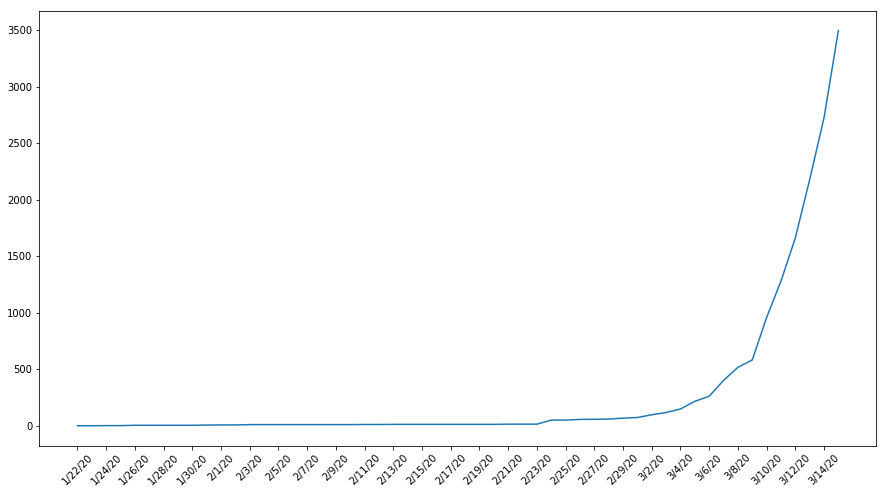

In [14]:
# plot the US confirmed covid-19 numbers
# prepare the data
dates = list(plot_df_confirmed_US.columns)
confirmed = list(plot_df_confirmed_US.values[0])
adjust_xticks = dates[::2]

# plot the data
plt.figure(figsize=[15,8])
plt.plot(dates, confirmed)
plt.xticks(adjust_xticks, rotation=45);



In [15]:
# removing unnecessary columns
df_confirmed_countries.drop(columns=['Lat', 'Long'], inplace=True)

# set the country/region column as index
df_confirmed_countries.set_index('Country/Region', inplace=True)


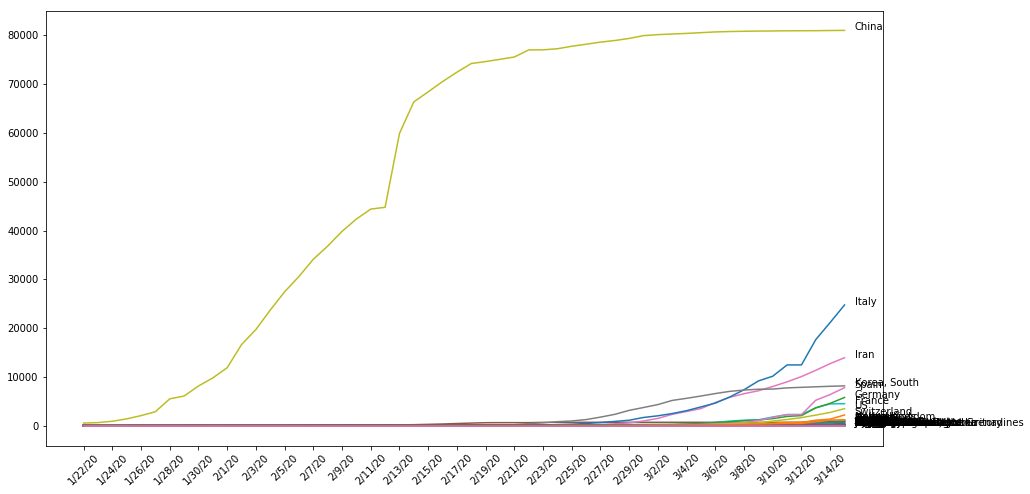

In [16]:
# plot all countries in one graph
plt.figure(figsize=[15,8])
for index, row in df_confirmed_countries.iterrows():
    plt.plot(dates, row)
    plt.annotate(index,xy=(plt.xticks()[0][-1]+0.7, row[-1]))

plt.xticks(adjust_xticks, rotation=45);
    

Based on the above graph, we can see that China has been able to contain the virus, with the growth rate significantly slowing over the past few days

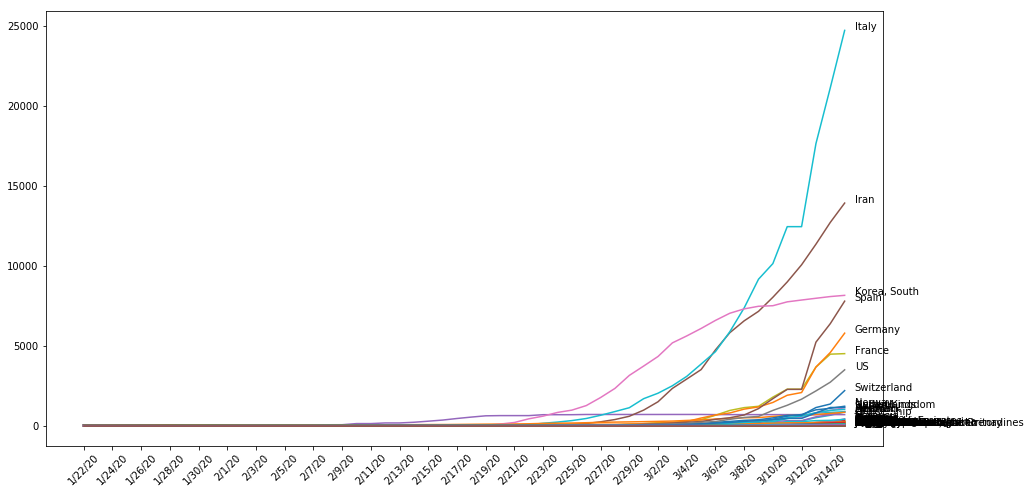

In [17]:
# plot all countries except for China
plt.figure(figsize=[15,8])
for index, row in df_confirmed_countries.iterrows():
    if index == 'China':
        pass
    else:
        plt.plot(dates, row)
        plt.annotate(index,xy=(plt.xticks()[0][-1]+0.7, row[-1]))

plt.xticks(adjust_xticks, rotation=45);


A slower growth rate can also be observed in the case of South Korea. On March 8th, Italy surpassed the number of cases in South Korea, while Iran surpassed South Korea two days later.

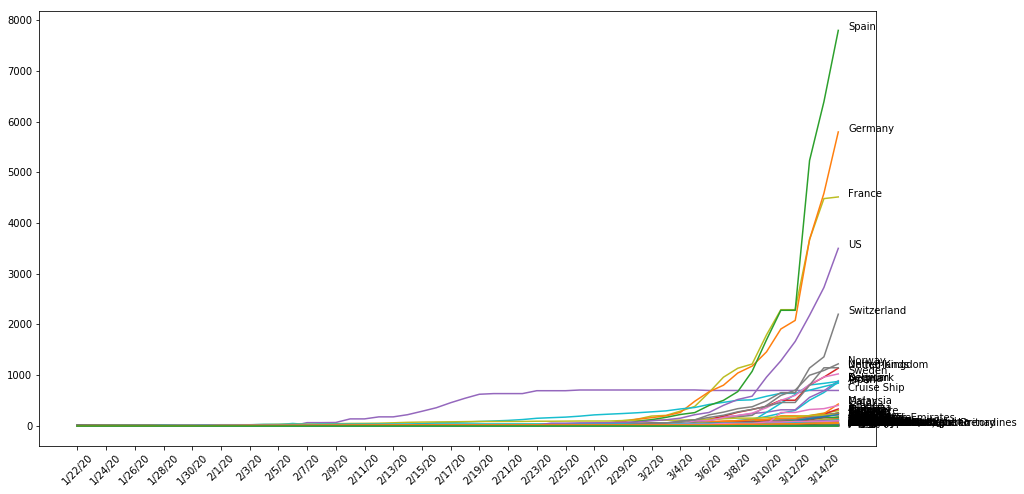

In [18]:
# plot all countries except for China, Italy, Iran and South Korea
plt.figure(figsize=[15,8])
for index, row in df_confirmed_countries.iterrows():
    if index == 'China' or index == 'Italy' or index == 'Iran' or index == 'Korea, South':
        pass
    else:
        plt.plot(dates, row)
        plt.annotate(index,xy=(plt.xticks()[0][-1]+0.7, row[-1]))

plt.xticks(adjust_xticks, rotation=45);


Looking at countries with less than 7,000 cases, it does not look like the growth is going to slow down any time soon. The horizontal line belongs to Cruise Ships, which were treated as their own region by the WHO. Their growth has slowed, mainly because the majority of cruise line operators have suspended their cruises amid the outbreak.

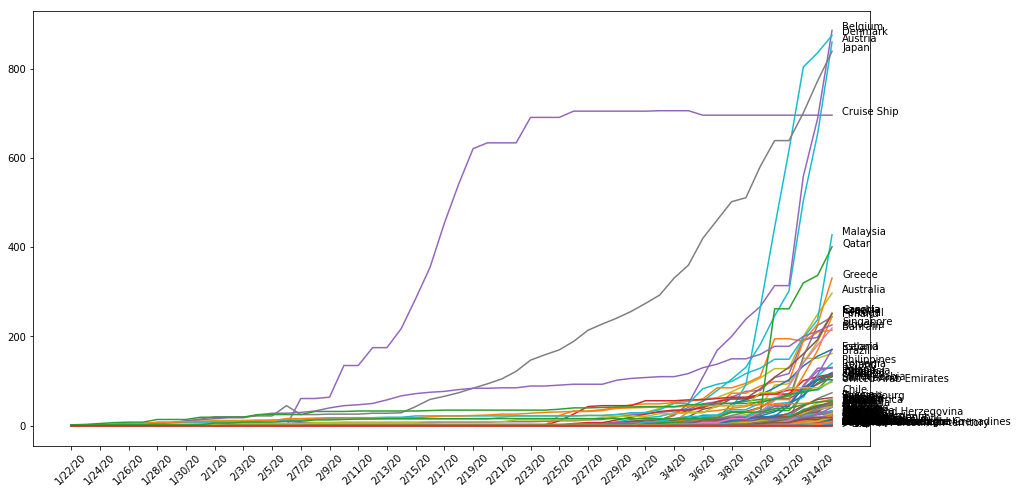

In [19]:
# plot all countries with less than 1000 cases
plt.figure(figsize=[15,8])
for index, row in df_confirmed_countries.iterrows():
    if row[-1] > 1000:
        pass
    else:
        plt.plot(dates, row)
        plt.annotate(index,xy=(plt.xticks()[0][-1]+0.7, row[-1]))

plt.xticks(adjust_xticks, rotation=45);


### News

In [20]:
# format the time so that grouping per day can be done
df_news['date'] = df_news['publish_date'].apply(lambda x: x[5:10])


In [21]:
# which news outlets are included in these news stories
df_news_politics['media_name'].unique()


array(['Milwaukee Journal Sentinel ', 'sfchronicle', 'Newsday',
       'The Daily Beast', 'Politico', 'Wall Street Journal',
       'The Sacramento Bee', 'LA Times', 'Star Tribune ',
       'The Kansas City Star', 'The Orange County Register',
       'Huffington Post', 'The Columbus Dispatch', 'bleacherreport.com',
       'The Baltimore Sun', 'Washington Post', 'San Jose Mercury News',
       'thisisinsider.com', 'Arkansas Democrat-Gazette ',
       'New York Times', 'Tampa Bay Times', 'St. Louis Post Dispatch',
       'digitaltrends.com', 'AZCentral', 'USA Today',
       'South Florida Sun-Sentinel', 'The Boston Globe',
       'Business Insider', 'HonululuAdvertiser', 'NY Post', 'Slate.com',
       'Mashable!', 'The Denver Post', 'Marketwatch',
       'The Atlanta Journal Constitution', 'freep.com', 'Daily News',
       'CNET', 'Seattle Times', 'blogs.indystar.com', 'cincinnati.com',
       'sandiegouniontribune.com', 'San Antonio Express News',
       'investopedia.com', 'Vox', 'St.P

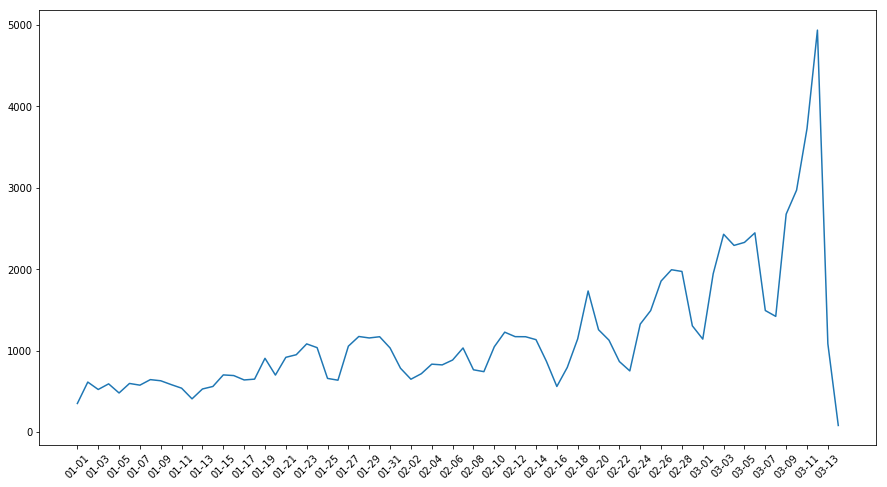

In [22]:
# get the story number for covid-19 related news
story_covid_cnt = df_news.groupby('date')['title'].count()

# plot the numbers
dates = list(story_covid_cnt.index)
story_count = list(story_covid_cnt.values)

plt.figure(figsize=[15,8])
plt.plot(dates, story_count)
adjust_xticks = dates[::2]
plt.xticks(adjust_xticks, rotation=45);


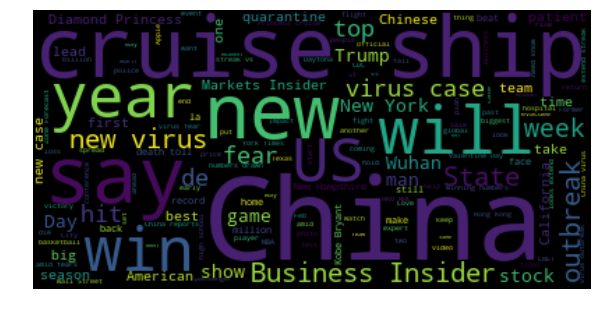

In [23]:
# get news from mid February
mid_Feb_news = df_news[(df_news['date'] > '02-10') & (df_news['date'] < '02-18')]

# create a wordcloud
add_words = ['coronavirus', 'covid']
stop_words = STOPWORDS.union(add_words)
mid_Feb_titles = mid_Feb_news['title'].str.cat(sep='. ')
wordcloud = WordCloud(stopwords=stop_words, random_state=42).generate(mid_Feb_titles)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


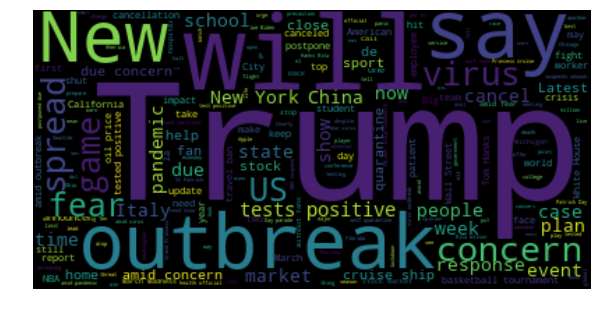

In [24]:
# get news from last week
last_week_news = df_news[df_news['date'] > '03-07']

# create a wordcloud
add_words = ['coronavirus', 'covid']
stop_words = STOPWORDS.union(add_words)
last_week_titles = last_week_news['title'].str.cat(sep='. ')
wordcloud = WordCloud(stopwords=stop_words, random_state=42).generate(last_week_titles)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


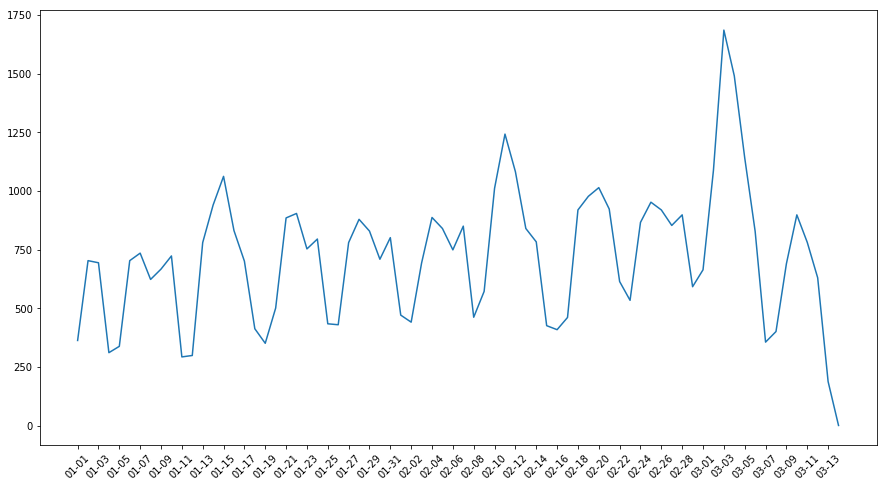

In [25]:
# make story count plot for 2020 election stories
df_news_politics['date'] = df_news_politics['publish_date'].apply(lambda x: x[5:10])

# get the story number for covid-19 related news
story_pol_cnt = df_news_politics.groupby('date')['title'].count()

# plot the numbers
dates_pol = list(story_pol_cnt.index)
story_count_pol = list(story_pol_cnt.values)

plt.figure(figsize=[15,8])
plt.plot(dates_pol, story_count_pol)
adjust_xticks = dates[::2]
plt.xticks(adjust_xticks, rotation=45);



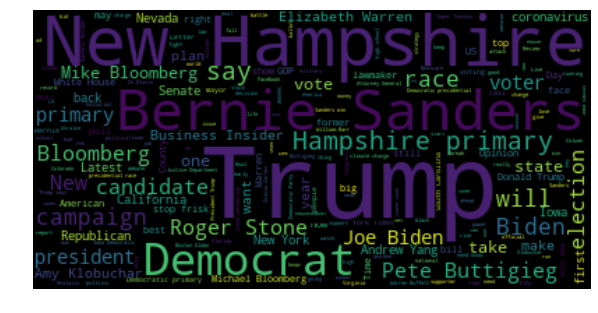

In [26]:
# get news from mid February
mid_Feb_news_pol = df_news_politics[(df_news_politics['date'] > '02-10') & (df_news_politics['date'] < '02-18')]

# create a wordcloud
stop_words = STOPWORDS
mid_Feb_titles = mid_Feb_news_pol['title'].str.cat(sep='. ')
wordcloud = WordCloud(stopwords=stop_words, random_state=42).generate(mid_Feb_titles)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


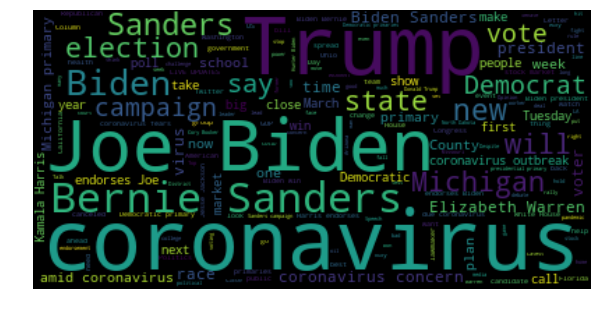

In [27]:
# get news from last week
last_week_news_pol = df_news_politics[df_news_politics['date'] > '03-07']

# create a wordcloud
#add_words = ['coronavirus', 'covid']
stop_words = STOPWORDS#.union(add_words)
last_week_titles = last_week_news_pol['title'].str.cat(sep='. ')
wordcloud = WordCloud(stopwords=stop_words, random_state=42).generate(last_week_titles)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


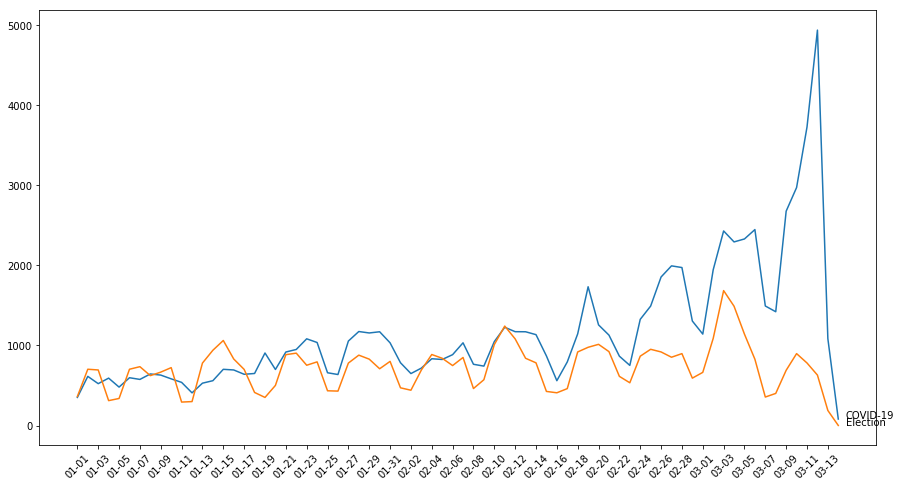

In [28]:
# plot story counts in one plot
plt.figure(figsize=[15,8])

plt.plot(dates, story_count)
plt.annotate('COVID-19',xy=(plt.xticks()[0][-1]+0.7, story_count[-1]))
plt.plot(dates, story_count_pol)
plt.annotate('Election',xy=(plt.xticks()[0][-1]+0.7, story_count_pol[-1]))

plt.xticks(adjust_xticks, rotation=45);



### Finance

In [33]:
# create year and month variable in df_fin dataframe 
df_fin['year'] = df_fin['Date'].apply(lambda x: x[:4])
df_fin['month'] = df_fin['Date'].apply(lambda x: x[5:7])
df_fin['day'] = df_fin['Date'].apply(lambda x: x[8:])
df_fin['datetime'] = df_fin['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_fin['week'] = df_fin['datetime'].apply(lambda x: x.strftime("%W"))

# drop any unnecessary columns
df_fin.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df_fin.head()


,Date,Adj Close,asset,year,month,day,datetime,week
0,1985-01-02,11.70,10y_bond,1985,01,02,1985-01-02,00
1,1985-01-03,11.62,10y_bond,1985,01,03,1985-01-03,00
2,1985-01-04,11.67,10y_bond,1985,01,04,1985-01-04,00
3,1985-01-06,NaN,10y_bond,1985,01,06,1985-01-06,00
4,1985-01-07,11.50,10y_bond,1985,01,07,1985-01-07,01


In [34]:
# interpolate missing values
df_fin['Adj Close'] = df_fin['Adj Close'].interpolate()


In [35]:
# create function to plot finance distributions
def plot_finance(df, period='month', time=None, skips=36):
    '''
    Function to create multiple plots that show the development
    of prices of financial assets
    Args: df = dataframe containing data on financial assets
          period = string; determines which period the prices should refer to (day, week, month)
          time = string; time frame for prices to be plotted
          skips = int; x axis label tick gaps
    Returns: None
    '''
    
    # get the asset names in the dataframe
    asset_names = df['asset'].unique()
    
    # assign the groupby's and new column names depending on the period
    if period == 'month':
        col = 'year_month'
        df[col] = df.apply(lambda x: x['year']+'-'+x['month'], axis=1)
        groupby = ['year_month', 'asset']
        
    elif period == 'week':
        col = 'year_week'
        df[col] = df.apply(lambda x: x['year']+'-'+str(x['week']), axis=1)
        df[col] = df.apply(lambda x: str(int(x['year'])+1)+'-'+str(x['week']) 
                                     if (x['month'] == str(12)) & (x['week'] == 1) 
                                     else x['year_week'], axis=1)
        groupby = ['year_week', 'asset']
        
    elif period == 'day':
        col = 'Date'
        groupby = ['Date', 'asset']
                
    # prepare the dataframe with period information
    df = df.groupby(groupby)['Adj Close'].mean()
    df = pd.DataFrame(df)
    df = df.reset_index()
    
    # plot prices for each asset    
    for name in asset_names:

        if time == None:
            x = df[df['asset'] == name][col].drop_duplicates()
            y = list(df[df['asset'] == name]['Adj Close'].values)
            adjust_xticks = list(x.values)[::skips]
        else: 
            x = df[df['asset'] == name][col].drop_duplicates()[-time:]
            y = list(df[df['asset'] == name]['Adj Close'].values)[-time:]
            adjust_xticks = (list(x.values)[-time:])[::skips]
            
        plt.figure(figsize=[15,8])
        plt.plot(x, y)
        plt.xticks(adjust_xticks, rotation=45)
        plt.title(name);
    
    return df
    

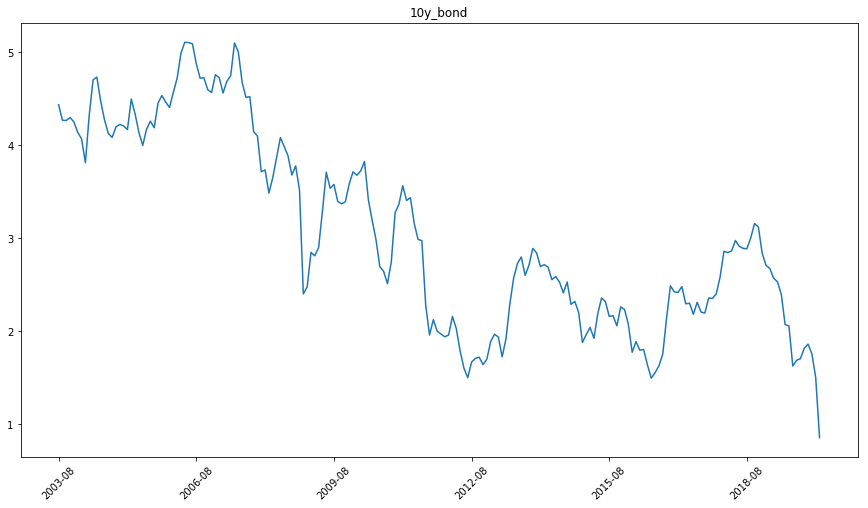

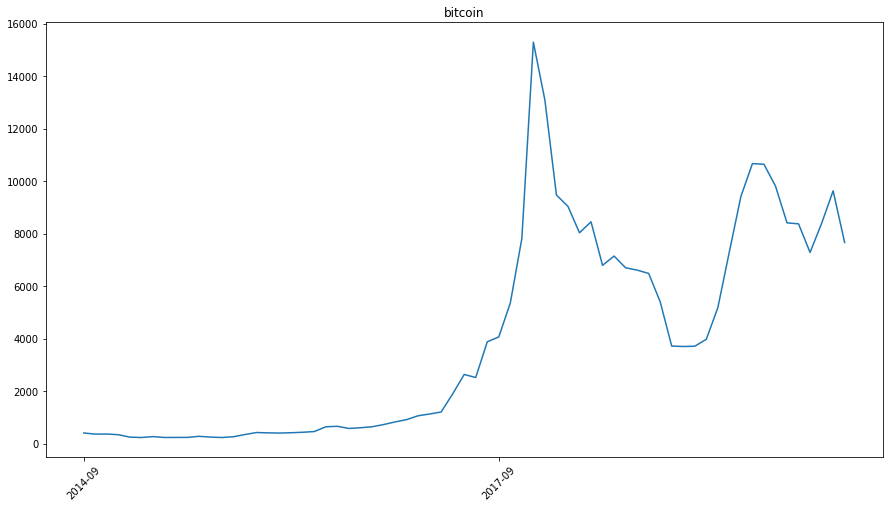

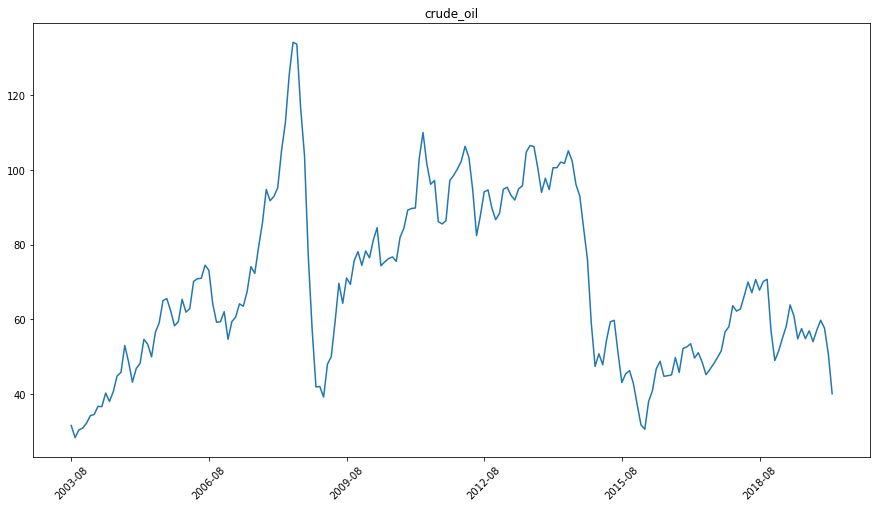

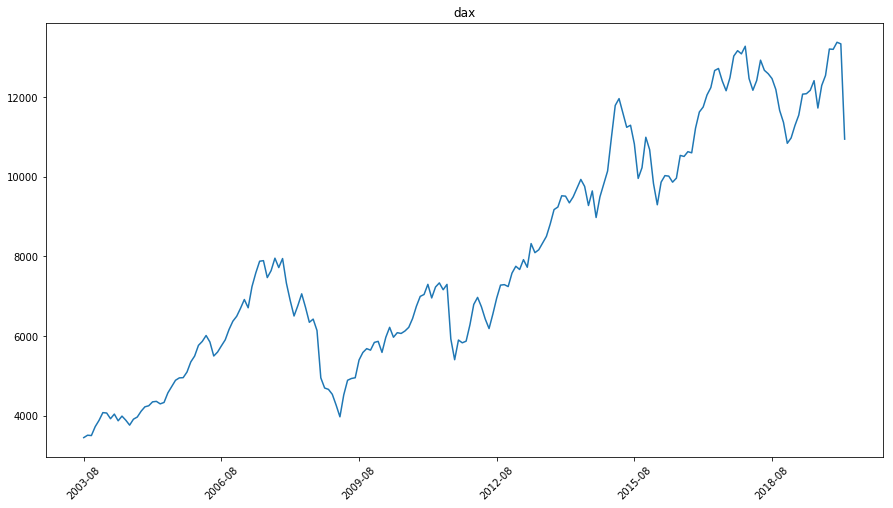

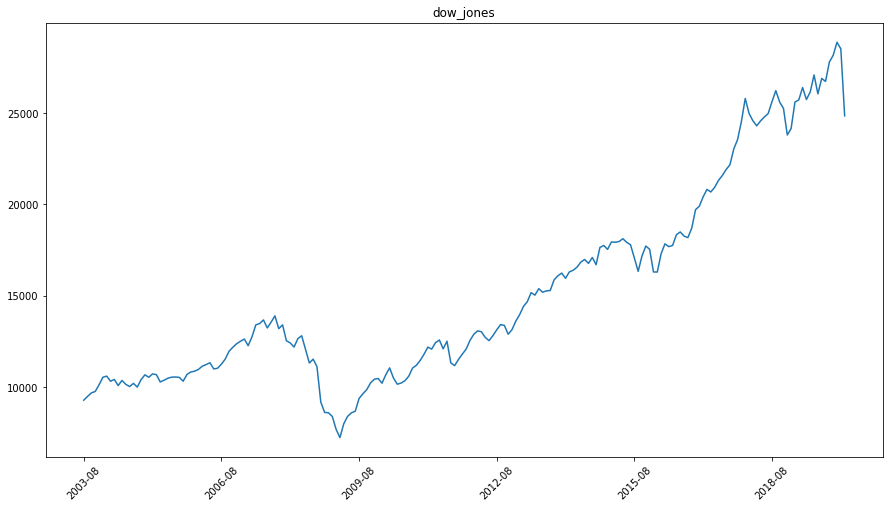

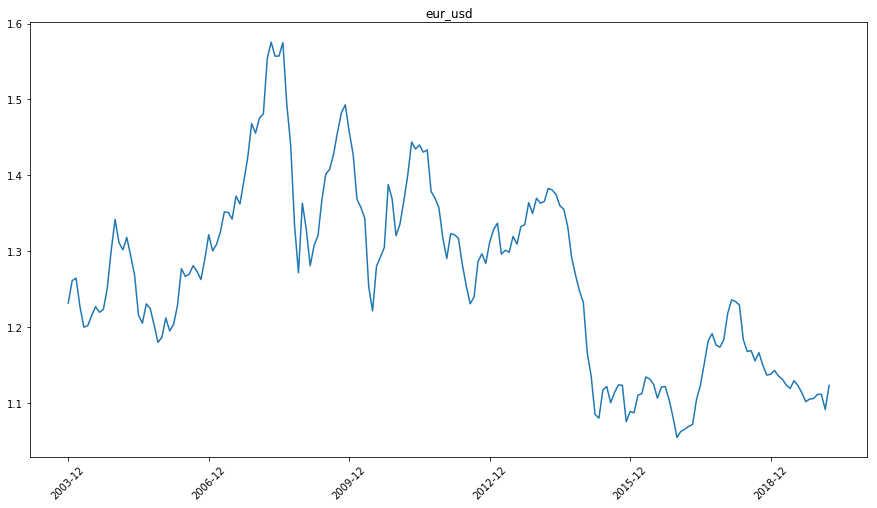

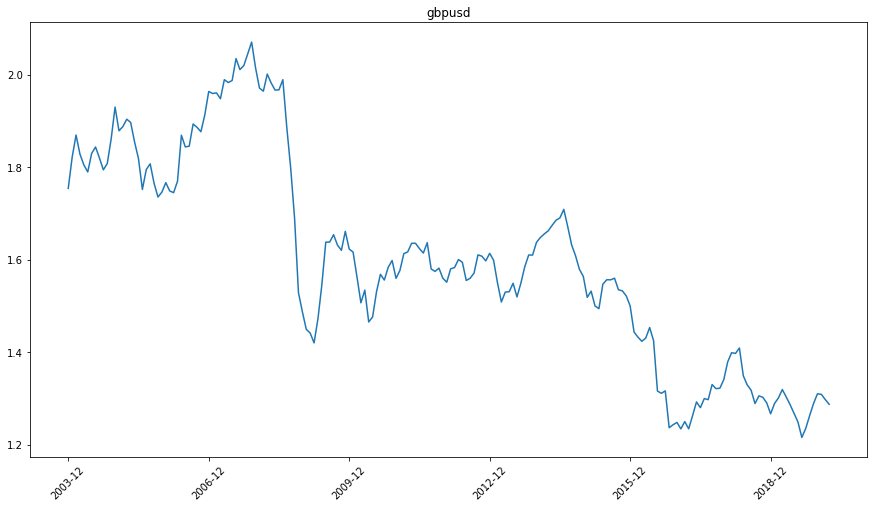

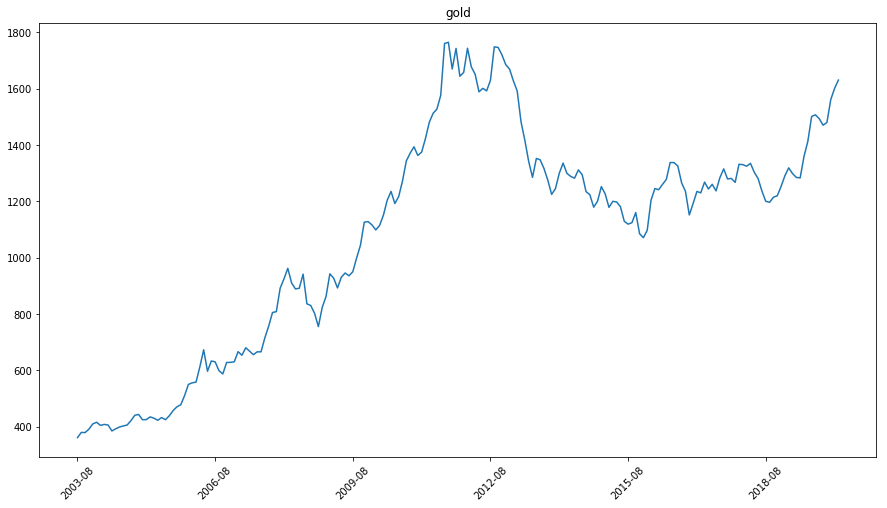

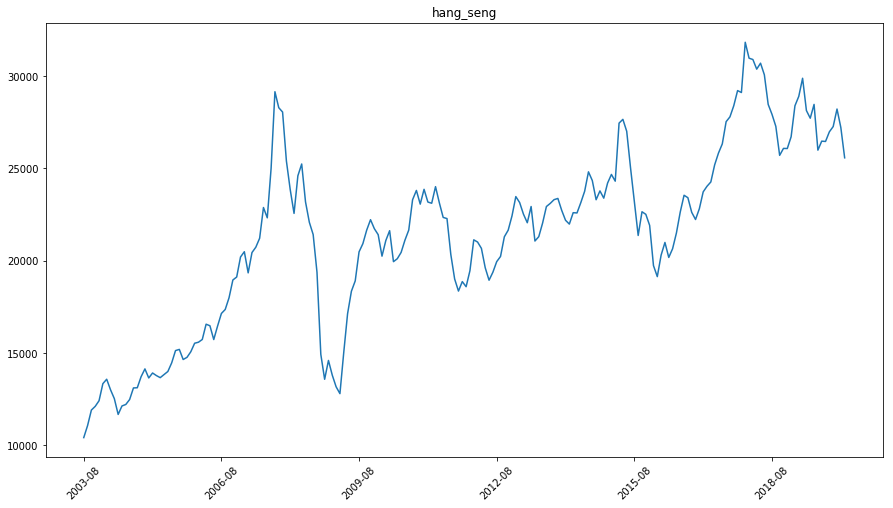

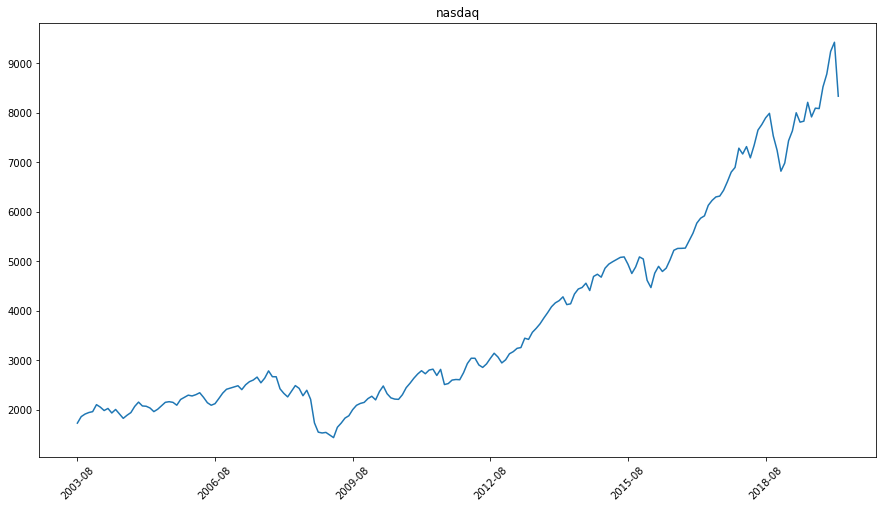

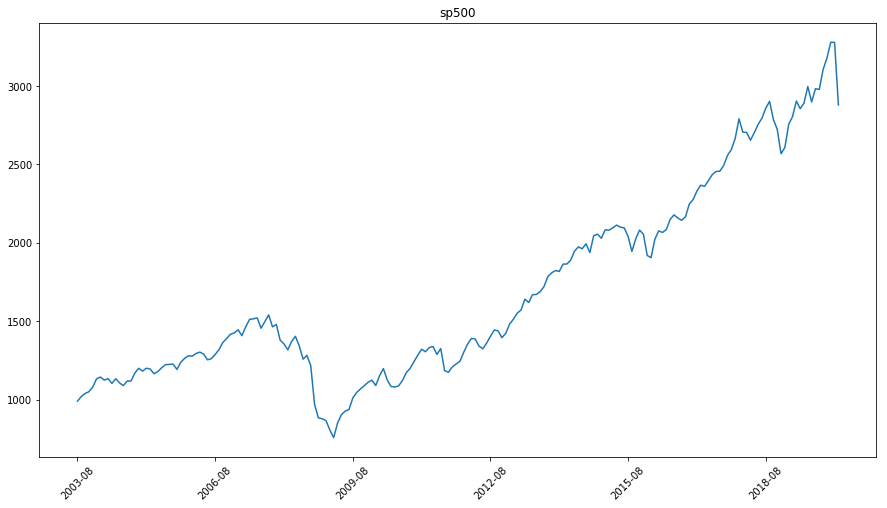

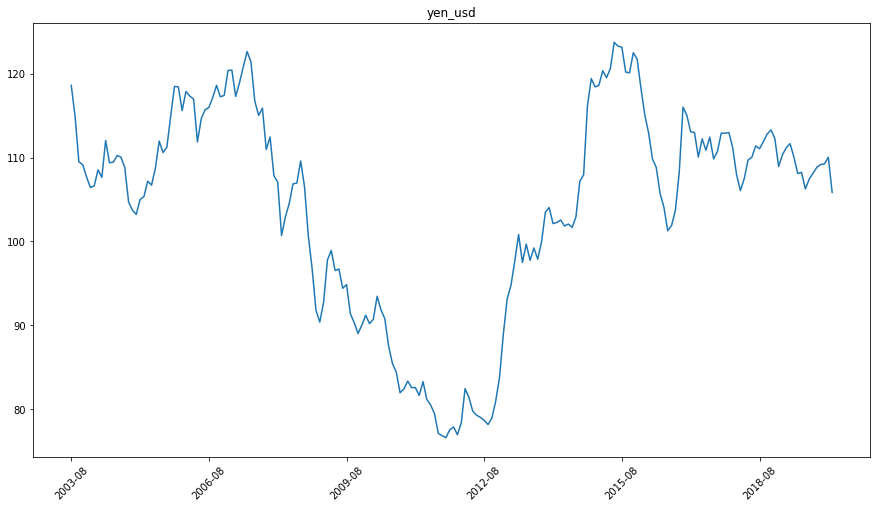

In [97]:
# plot all prices for the specified time for all assets
df_new = plot_finance(df_fin, period='month', time=200, skips=36)


In [109]:
# pivot the dataframe to prepare it for plotting
df_fin_all = df_fin.pivot(index='Date', columns='asset', values='Adj Close')
df_fin_all.reset_index(inplace=True)

# create year and month variable in df_fin_all dataframe 
df_fin_all['year'] = df_fin_all['Date'].apply(lambda x: x[:4])
df_fin_all['month'] = df_fin_all['Date'].apply(lambda x: x[5:7])
df_fin_all['day'] = df_fin_all['Date'].apply(lambda x: x[8:])
df_fin_all['datetime'] = df_fin_all['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_fin_all['week'] = df_fin_all['datetime'].apply(lambda x: x.strftime("%W"))
df_fin_all['year_month'] = df_fin_all.apply(lambda x: x['year']+'-'+x['month'], axis=1)
df_fin_all['year_week'] = df_fin_all.apply(lambda x: x['year']+'-'+str(x['week']), axis=1)
df_fin_all['year_week'] = df_fin_all.apply(lambda x: str(int(x['year'])+1)+'-'+str(x['week']) 
                                     if (x['month'] == str(12)) & (x['week'] == '01') 
                                     else x['year_week'], axis=1)

df_fin_all.head()


asset,Date,10y_bond,bitcoin,crude_oil,dax,dow_jones,eur_usd,gbpusd,gold,hang_seng,nasdaq,sp500,yen_usd,year,month,day,datetime,week,year_month,year_week
0,1971-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,1971,02,05,1971-02-05,05,1971-02,1971-05
1,1971-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.839996,NaN,NaN,1971,02,08,1971-02-08,06,1971-02,1971-06
2,1971-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.760002,NaN,NaN,1971,02,09,1971-02-09,06,1971-02,1971-06
3,1971-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.690002,NaN,NaN,1971,02,10,1971-02-10,06,1971-02,1971-06
4,1971-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.449997,NaN,NaN,1971,02,11,1971-02-11,06,1971-02,1971-06


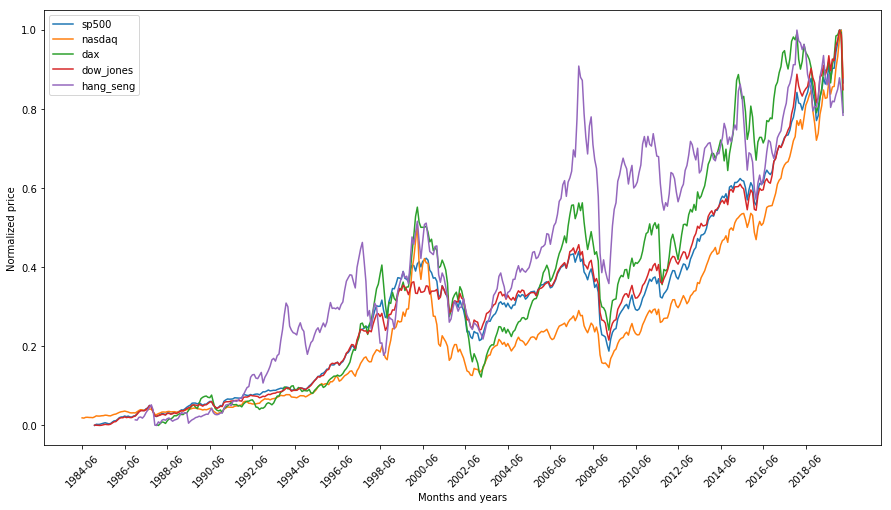

In [131]:
# create monthly average prices
columns = list(df_fin_all.columns)[1:13]
df_fin_month = df_fin_all.groupby('year_month')[columns].mean()
df_fin_month.reset_index(inplace=True)

# normalize all values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(df_fin_month[columns])
df_fin_month_norm = pd.DataFrame(x_scaled, columns=columns)
df_fin_month_norm['year_month'] = df_fin_month['year_month']

# plot all stocks in one graph
assets = ['sp500', 'nasdaq', 'dax', 'dow_jones', 'hang_seng']
x = list(df_fin_month_norm['year_month'])

plt.figure(figsize=[15,8])

for asset in assets:
    plt.plot(x[-430:], list(df_fin_month_norm[asset].values)[-430:])

adjust_xticks = (x[-430:])[::24]
plt.xticks(adjust_xticks, rotation=45)
plt.xlabel('Months and years')
plt.ylabel('Normalized price')
plt.legend(assets)
plt.show()


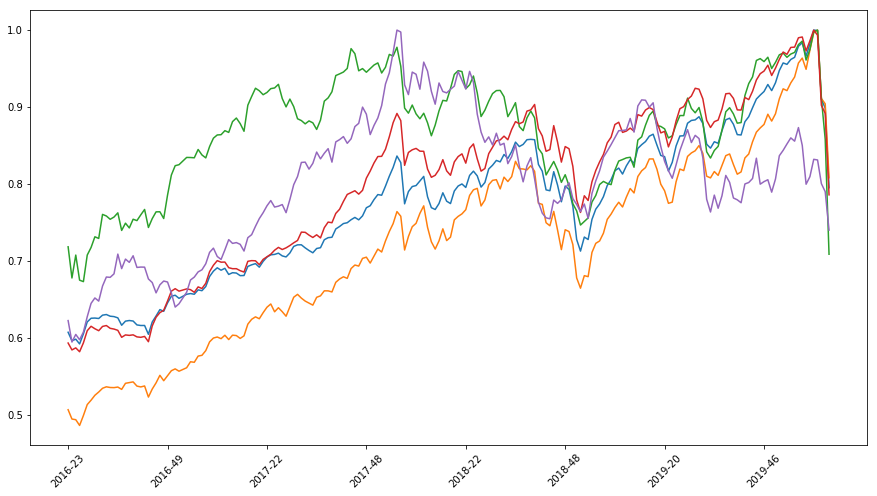

In [121]:
# create weekly average prices
columns = list(df_fin_all.columns)[1:13]
df_fin_week = df_fin_all.groupby('year_week')[columns].mean()
df_fin_week = df_fin_week.interpolate()
df_fin_week.reset_index(inplace=True)

# normalize all values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(df_fin_week[columns])
df_fin_week_norm = pd.DataFrame(x_scaled, columns=columns)
df_fin_week_norm['year_week'] = df_fin_week['year_week']

# plot all stocks in one graph
assets = ['sp500', 'nasdaq', 'dax', 'dow_jones', 'hang_seng']
x = list(df_fin_week_norm['year_week'])

plt.figure(figsize=[15,8])

for asset in assets:
    plt.plot(x[-200:], list(df_fin_week_norm[asset].values)[-200:])

adjust_xticks = (x[-200:])[::26]
plt.xticks(adjust_xticks, rotation=45)
plt.show()


In [122]:
df_fin_all.head()

asset,Date,10y_bond,bitcoin,crude_oil,dax,dow_jones,eur_usd,gbpusd,gold,hang_seng,nasdaq,sp500,yen_usd,year,month,day,datetime,week,year_month,year_week
0,1971-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,1971,02,05,1971-02-05,05,1971-02,1971-05
1,1971-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.839996,NaN,NaN,1971,02,08,1971-02-08,06,1971-02,1971-06
2,1971-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.760002,NaN,NaN,1971,02,09,1971-02-09,06,1971-02,1971-06
3,1971-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.690002,NaN,NaN,1971,02,10,1971-02-10,06,1971-02,1971-06
4,1971-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.449997,NaN,NaN,1971,02,11,1971-02-11,06,1971-02,1971-06


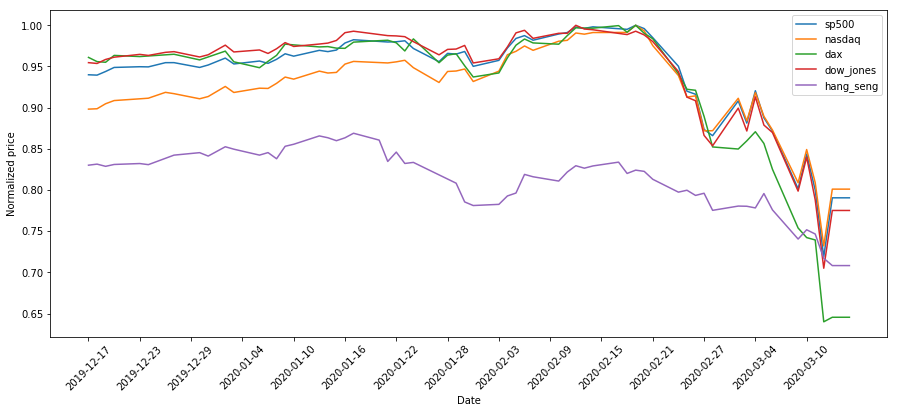

In [133]:
# plot daily prices
columns = list(df_fin_all.columns)[1:13]
df_fin_all = df_fin_all.interpolate()

# normalize all values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(df_fin_all[columns])
df_fin_all_norm = pd.DataFrame(x_scaled, columns=columns)
df_fin_all_norm['Date'] = df_fin_all['Date']

# plot all stocks in one graph
assets = ['sp500', 'nasdaq', 'dax', 'dow_jones', 'hang_seng']
x = list(df_fin_all_norm['Date'])

plt.figure(figsize=[15,6])

for asset in assets:
    plt.plot(x[-90:], list(df_fin_all_norm[asset].values)[-90:])

adjust_xticks = (x[-90:])[::6]
plt.xticks(adjust_xticks, rotation=45)
plt.xlabel('Date')
plt.ylabel('Normalized price')
plt.legend(assets)
plt.show()


In [149]:
# get the days with the biggest losses
df_fin_all_diff = df_fin_all.drop(columns=['year', 'month', 'day', 'datetime', 'week', 'year_month', 'year_week'])
df_fin_all_diff.set_index('Date', inplace=True)

df_fin_all_diff = df_fin_all_diff.pct_change()

print(df_fin_all_diff['sp500'].nsmallest(10, keep='all'))
print(df_fin_all_diff['sp500'].nlargest(10, keep='all'))


Date
1987-10-19   -0.114001
1987-10-18   -0.102335
2020-03-12   -0.095113
2008-10-15   -0.090350
2008-10-09   -0.076167
1988-01-08   -0.067683
2008-11-20   -0.067123
1989-10-13   -0.061172
2008-11-19   -0.061156
2008-10-22   -0.061012
Name: sp500, dtype: float64
Date
2008-10-28    0.107890
2020-03-13    0.092871
1987-10-21    0.090994
2008-11-13    0.069213
2009-03-10    0.063663
2008-11-21    0.063248
2008-10-12    0.057900
2002-07-24    0.057327
2008-10-13    0.054731
2008-09-30    0.054175
Name: sp500, dtype: float64


## The economic consequences
* global supply chains
* China is recovering
* stock markets and other financial assets
* what about other significant losses in history? How long until recovery?




## The political consequences
* Trump approval ratings
* fear of voters of corona virus
* news about corona versus news about biden, sanders and campaigns


